<a href="https://colab.research.google.com/github/Astatine404/IFT6390_KaggleComp1/blob/main/LogReg_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

In [1]:
import math
import numpy as np
import urllib.request
import random
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

In [2]:
def minmax_scale(X, max, min):
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X_scaled = X_std * (max - min) + min
    return X_scaled

def standardize(X):
  return (X - X.mean(axis=0)) / X.std(axis=0)

In [4]:
data = np.loadtxt(urllib.request.urlopen("https://transfer.sh/dlcC5z/train.csv"), delimiter=",", skiprows=1)

# Remove index column 
data = data[:, 1:]

# Remove duplicates
df = pd.DataFrame(data=data)
df = df.drop_duplicates()
data = df.to_numpy()

# Random Undersampling of class 0
del_ind_ = np.where(data[:, -1] == 0)[0]
del_ind_ = np.random.choice(del_ind_, 7000, replace=False)
data = np.delete(data, del_ind_, axis=0)

# Number of classes
n_classes = 3
# Size of training set
n_train = math.floor(0.9 * data.shape[0])

# Seed the randomizer
random.seed(890)
# Randomly choose indexes for the train and test dataset
inds = list(range(data.shape[0]))
random.shuffle(inds)
train_inds = inds[:n_train]
test_inds = inds[n_train:]

# Split the data into train and test sets
train_set = data[train_inds, :]
test_set = data[test_inds, :]

# Resample to address class imbalance
# from sklearn.utils import resample

# labels = train_set[:, -1]
# features = train_set[:, :-1]
# majority_size = labels[labels == 0].size
# minority_1 = train_set[labels == 1]
# minority_2 = train_set[labels == 2]

# minority_1_aug = resample(minority_1, replace=True, n_samples=(majority_size - minority_1.shape[0])//2)
# minority_2_aug = resample(minority_2, replace=True, n_samples=(majority_size - minority_2.shape[0])//2)

# train_set = np.concatenate((train_set, minority_1_aug, minority_2_aug))

#Separate the test set into inputs and labels
test_inputs = test_set[:, :-1]
test_labels = test_set[:, -1].astype('int32')
train_inputs = train_set[:, :-1]
train_labels = train_set[:, -1].astype('int32')

train_inputs_scaled = standardize(train_inputs)
test_inputs_scaled = (test_inputs - train_inputs.mean(axis=0)) / train_inputs.std(axis=0)
print(Counter(train_labels))

Counter({0: 11101, 2: 4695, 1: 1090})


Text(0, 0.5, 'Frequency')

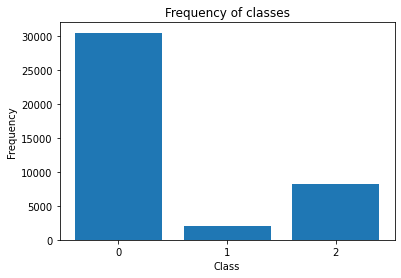

In [22]:
labels = data[:, -1]
height = [labels[labels==0].size, labels[labels==1].size, labels[labels==2].size]
plt.bar(np.unique(labels), height=height)
plt.xticks(range(0,3))
plt.title("Frequency of classes")
plt.xlabel("Class")
plt.ylabel("Frequency")



# Feature Selection (only for visualisation)

Text(0, 0.5, 'Chi2 score')

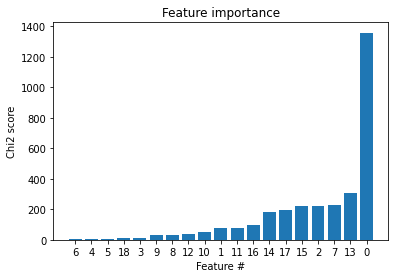

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

feat_selector = SelectKBest(chi2, k=7)
train_inputs_minmax = (train_inputs_scaled - train_inputs_scaled.min(axis=0)) / (train_inputs_scaled.max(axis=0) - train_inputs_scaled.min(axis=0))
feat_selector.fit(train_inputs_minmax, train_labels)
# train_inputs_scaled = train_inputs_scaled[:, feat_selector.get_support(indices=True)]
# test_inputs_scaled = test_inputs_scaled[:, feat_selector.get_support(indices=True)]
feature_nos = np.arange(feat_selector.scores_.size)
feature_nos = feature_nos[np.argsort(feat_selector.scores_)].astype('str')
feat_selector.scores_.sort()
plt.bar(feature_nos, feat_selector.scores_)
plt.xticks(feature_nos)
plt.title("Feature importance")
plt.xlabel("Feature #")
plt.ylabel("Chi2 score")

# Training

In [5]:
def softmax(z):
  soft = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T 
  return soft

In [6]:
def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

In [7]:
def shuffle_batch(x, y):
  assert x.shape[0] == y.shape[0]
  inds = list(range(x.shape[0]))
  np.random.shuffle(np.array(inds))
  return x[inds, :], y[inds]

In [8]:
def confusion_matrix(true_labels, pred_labels):

    matrix = np.zeros((n_classes, n_classes))

    for (true, pred) in zip(true_labels, pred_labels):
        matrix[true][pred] += 1
        pass

    return matrix.astype('int32')

def add_intercept(X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

In [ ]:
!pip install cupy-cuda111

In [14]:
import cupy as np
import numpy as np1
import pandas as pd
import sys
from sklearn.metrics import recall_score, roc_auc_score

class LinearClassifier:

  def loss(self, X, Y, W, mu):
      Z = - X @ W     # examples x classes
      N = X.shape[0]
      P = softmax(Z)
      loss = 1/N * ((-np.sum(Y * np.log(P))) + mu * (W ** 2).sum())
      return loss

  def gradient(self, X, Y, W, mu):
      Z = - X @ W
      P = softmax(Z)
      N = X.shape[0]
      gd = 1/N * ((X.T @ (Y - P)) + 2 * mu * W)       # examples x features
      return gd

  def gradient_descent(self, X, Y, max_iter=1000, eta=0.005, mu=0.5, batch_size=256):
      Y_onehot = one_hot(Y, 3)
      W = np.zeros((X.shape[1] + 1, Y_onehot.shape[1]))
      X = add_intercept(X)
      step = 0
      step_lst = [] 
      loss_lst = []
      W_lst = []
  
      while step < max_iter:
        prev_loss = 0
        loss_iter = 0
        x, y = shuffle_batch(X, Y_onehot)
        # W -= eta * self.gradient(x, y, W, mu)
        # loss_iter = self.loss(x, y, W, mu)
        for start in range(0, x.shape[0], batch_size):
          stop = start + batch_size
          x_ = x[start:stop, :]
          y_ = y[start:stop]
          W -= eta * self.gradient(x_, y_, W, mu)
          loss_iter += self.loss(x_, y_, W, mu)
        step += 1
        loss_iter /= (x.shape[0] // batch_size)
        step_lst.append(step)
        W_lst.append(W)
        loss_lst.append(loss_iter)
        train_score = (self.predict(np.array(X), W, train=True) == np.array(Y)).mean() * 100
        test_pred = self.predict(np.array(test_inputs_scaled), W)
        test_score = (test_pred == np.array(test_labels)).mean() * 100
        recall = recall_score(test_labels, np.asnumpy(test_pred), average=None)
        roc=0
        if step % 10 == 0:
          print("step: {:d} loss: {:.4f} train %: {:.4f} test %: {:.4f} recall %:"
          .format(step, loss_iter, train_score, test_score), recall)
          #eta = 100/step
          

      df = pd.DataFrame({
          'step': step_lst, 
          'loss': loss_lst
      })

      # class wise accuracy
      for label in range(3):
        print("Class", label, (self.predict(np.array(test_inputs_scaled[np1.argwhere(test_labels == label).T[0], :]), W, final=True) == label).mean() * 100, "%")
      return df, W

In [10]:
class Multiclass(LinearClassifier):
    def fit(self, X, Y):
        self.loss_steps, self.W = self.gradient_descent(X, Y)

    def loss_plot(self):
        return self.loss_steps.astype(float).plot(
            x='step', 
            y='loss',
            xlabel='step',
            ylabel='loss'
        )

    def predict(self, H, W, train=False, final=False):
        if not train:
          H = add_intercept(H)
        Z = - H @ W
        P = softmax(Z)
        return np.argmax(P, axis=1)


    def predict_prob(self, H, W, train=False):
        if not train:
          H = add_intercept(H)
        Z = - H @ W
        P = softmax(Z)
        return P

In [11]:
X = np.array(train_inputs_scaled)
Y = np.array(train_labels)

In [ ]:
model = Multiclass()
model.fit(X, Y)

step: 10 loss: 0.7401 train %: 70.6680 test %: 69.8988 recall %: [0.86792453 0.14285714 0.44360902]
step: 20 loss: 0.6732 train %: 71.6925 test %: 71.6569 recall %: [0.90484003 0.13492063 0.42293233]
step: 30 loss: 0.6490 train %: 72.1130 test %: 72.5626 recall %: [0.91796555 0.11904762 0.42857143]
step: 40 loss: 0.6370 train %: 72.6815 test %: 72.6692 recall %: [0.91960623 0.12698413 0.42669173]
step: 50 loss: 0.6301 train %: 72.8355 test %: 72.9355 recall %: [0.91796555 0.14285714 0.43609023]
step: 60 loss: 0.6257 train %: 73.0605 test %: 72.9355 recall %: [0.91632486 0.16666667 0.43421053]
step: 70 loss: 0.6227 train %: 73.2263 test %: 73.0954 recall %: [0.91468417 0.1984127  0.43609023]
step: 80 loss: 0.6205 train %: 73.3448 test %: 73.0421 recall %: [0.91222313 0.20634921 0.43796992]
step: 90 loss: 0.6189 train %: 73.3744 test %: 73.2552 recall %: [0.91222313 0.22222222 0.44172932]
step: 100 loss: 0.6176 train %: 73.4632 test %: 73.3085 recall %: [0.91140279 0.23015873 0.44360902]

# Evaluation

In [ ]:
from sklearn.metrics import classification_report
import cupy as np
print(classification_report(test_labels, np.asnumpy(model.predict(np.array(test_inputs_scaled), model.W)), digits=4))
confusion_matrix(test_labels, np.asnumpy(model.predict(np.array(test_inputs_scaled), model.W)))

              precision    recall  f1-score   support

           0     0.7524    0.9098    0.8236      1219
           1     0.7551    0.2937    0.4229       126
           2     0.7090    0.4718    0.5666       532

    accuracy                         0.7443      1877
   macro avg     0.7388    0.5584    0.6044      1877
weighted avg     0.7403    0.7443    0.7239      1877



array([[1109,    7,  103],
       [  89,   37,    0],
       [ 276,    5,  251]], dtype=int32)

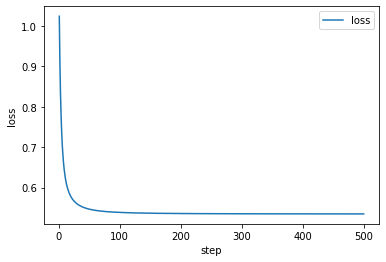

In [ ]:
model.loss_plot()

In [ ]:
import numpy as np
kaggle_data = np.loadtxt(urllib.request.urlopen("https://transfer.sh/lCFfeo/test.csv"), delimiter=",", skiprows=1)
kaggle_data = kaggle_data[:, 1:]
#pred = custom_predict(classifier, classifier2, kaggle_data)
import cupy as np
kaggle_data = standardize(np.array(kaggle_data))
pred = np.asnumpy(model.predict(kaggle_data, model.W))
import numpy as np
print(pred[pred==0].size / pred.size, pred[pred==1].size / pred.size, pred[pred==2].size / pred.size)
indices = np.array(list(i for i in range(pred.size)))
result = np.empty((pred.size, 2))
result[:, 0] = indices
result[:, 1] = pred
pd.DataFrame(data=result).tail(10)

0.7942622950819672 0.017759562841530054 0.18797814207650274


,0,1
7310,7310.0,0.0
7311,7311.0,0.0
7312,7312.0,0.0
7313,7313.0,0.0
7314,7314.0,0.0
7315,7315.0,0.0
7316,7316.0,0.0
7317,7317.0,0.0
7318,7318.0,0.0
7319,7319.0,0.0


In [ ]:
import numpy as np
np.savetxt('result_9.csv', result, fmt="%d", delimiter=",")
!curl --upload-file ./result_9.csv http://transfer.sh/result_9.csv

http://transfer.sh/At94Kl/result_9.csv

In [36]:
lr05 = model005.loss_steps[:500]

In [40]:
lr01 = model01.loss_steps

In [44]:
lr005 = model05.loss_steps

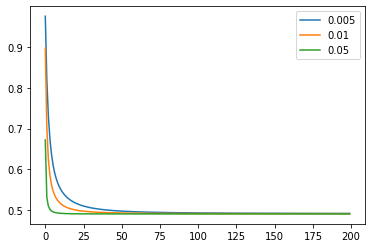

In [56]:
plt.plot(lr005[:200]['loss'].astype(float), label='0.005')
plt.plot(lr01[:200]['loss'].astype(float), label='0.01')
plt.plot(lr05[:200]['loss'].astype(float), label='0.05')
plt.legend(loc="upper right")